# `Modeling`



`import necessary libraries`

In [3]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random 


### `loading the provider dataset`

In [4]:
provider = pd.read_csv('provider.csv')
provider.drop(provider.columns[0], axis=1, inplace=True)
provider.head()

,Provider,inp_out,inp_out.1,ClmAdmitDiagnosisCode,DiagnosisGroupCode,AttendingPhysician,OperatingPhysician,OtherPhysician,ChronicCond_Alzheimer,ChronicCond_Heartfailure,...,settlement_days.1,Days_Admit,Total_deductible,Total_deductible.1,Total_reimbursible,Total_reimbursible.1,ClaimID,State,County,PotentialFraud
0,PRV51001,20,5,11,5,14,5,8,15,19,...,0,1.000000,1361.040000,34026,20221.200000,505530,25,1,7,0
1,PRV51003,70,62,58,58,44,7,22,56,80,...,0,2.424242,1668.545455,220248,10246.363636,1352520,132,3,23,1
2,PRV51004,149,0,25,0,38,19,26,64,88,...,0,0.000000,1057.704698,157598,6546.778523,975470,149,9,28,0
3,PRV51005,1164,0,158,0,6,6,4,426,679,...,0,0.000000,1013.544674,1179766,5531.168385,6438280,1165,4,26,1
4,PRV51007,69,3,17,3,10,5,7,26,40,...,0,0.222222,914.722222,65860,4779.722222,344140,72,2,6,0


In [5]:
#changing the rpocider column from stting to integer
provider['Provider'] = provider['Provider'].str.extract('(\d+)').astype(int)


### `Train-Test Split for Potential Fraud Prediction`
we split the data with the default train-test split ratio is 0.75 for the train set and 0.25 for the test set.

In [6]:

# Perform train-test split for potential fraud prediction
X = provider.drop(columns = ['PotentialFraud', 'Provider'], axis = 1)
y = provider['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4328, 39)
X_test shape: (1082, 39)
y_train shape: (4328,)
y_test shape: (1082,)


`Feature Importances in Random Forest Classifier`

In [7]:
r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

`visualizing feature importances`

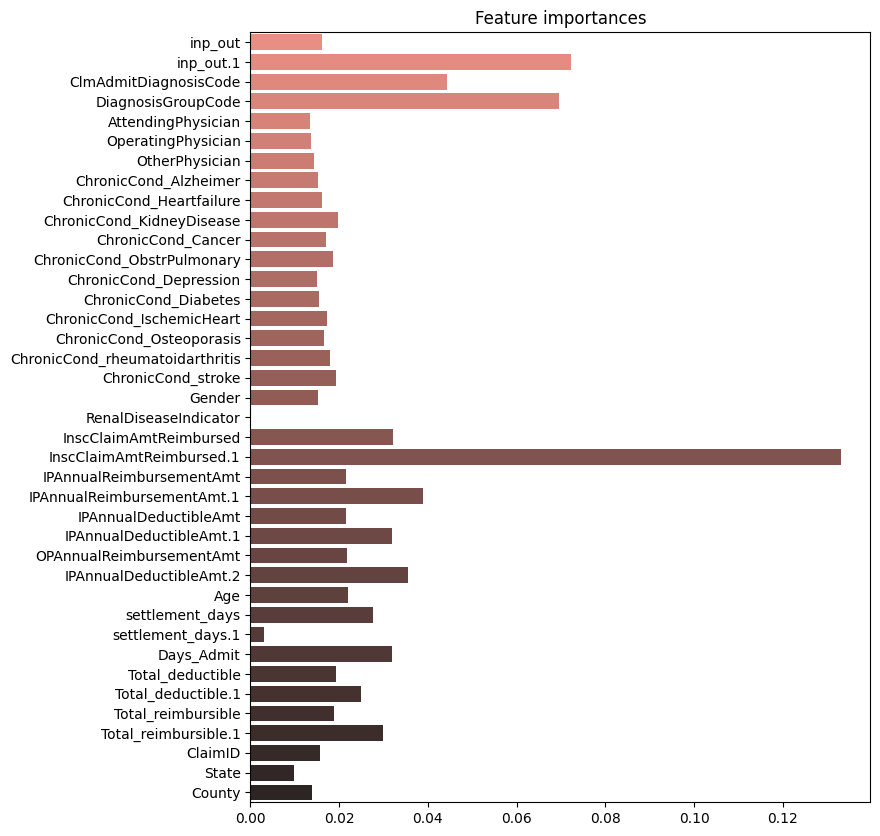

In [8]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

In [9]:
#dropping less important features
coef=coef[coef<0.005].index
X_train.drop(coef,axis=1,inplace=True)
X_test.drop(coef,axis=1,inplace=True)

In [10]:

r_cfl=RandomForestClassifier(n_estimators=1000,random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

`visualizing feature importances after dropping less important features`

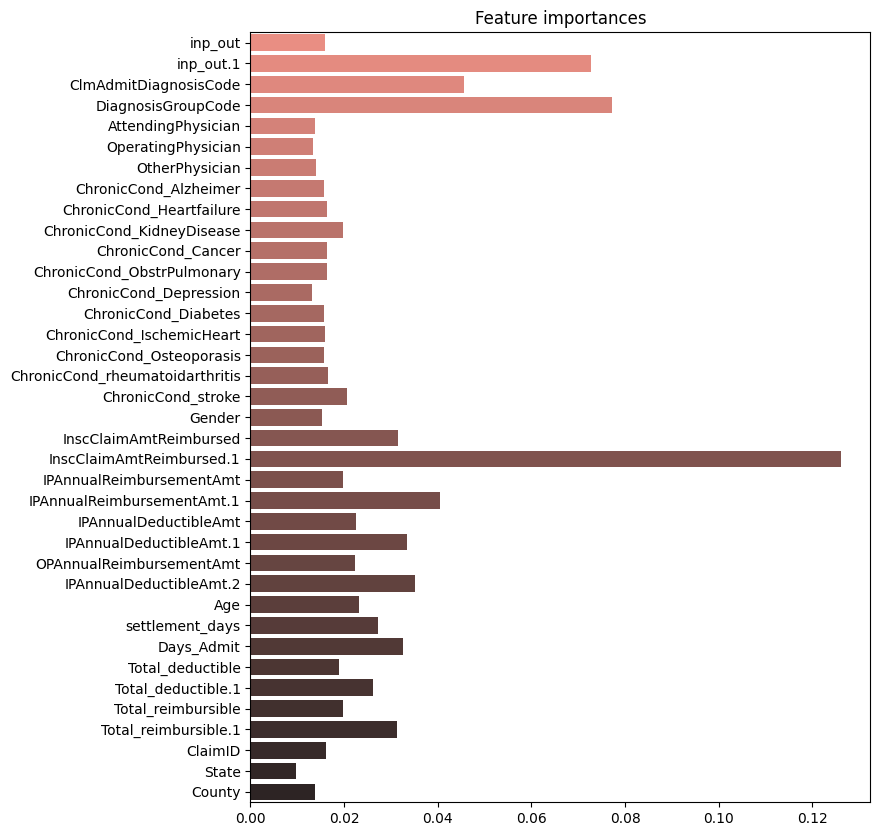

In [11]:
features=X_train.columns
coef = pd.Series(r_cfl.feature_importances_,features).sort_values()
plt.figure(figsize=(8,10))
plt.title('Feature importances')
sns.barplot(x=r_cfl.feature_importances_,y=features,palette='dark:salmon_r')
plt.show()

###  `Creating class for modelling`


In [12]:
class BinaryClassificationModel:
    def __init__(self, classifier):
        self.classifier = classifier
    
    def train_and_predict(self, X_train, y_train, X_test):
        """Train the model on the training data and make predictions on the test data"""
        self.classifier.fit(X_train, y_train)
        self.y_pred = self.classifier.predict(X_test)
    
    def evaluate(self, y_test):
        """Evaluate the performance of the model using various metrics"""
        auc = roc_auc_score(y_test, self.y_pred)
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1_score(y_test, self.y_pred, average='weighted'):.2%}")
        print("-----------------------------------------------")
        print("Classification Report:")
        print(classification_report(y_test, self.y_pred))

    def plot_confusion_matrix(self, y_test, cmap='GnBu'):
        """Display confusion matrix"""
        cm = confusion_matrix(y_test, self.y_pred)
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=['not_fraud', 'fraud'],
               yticklabels=['not_fraud', 'fraud'],
               xlabel='Predicted label',
               ylabel='True label',
               title='Confusion Matrix')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fmt = '.4g'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "darkblue")
        ax.grid(False)
        fig.tight_layout()
        plt.show()
    
    def plot_roc_curve(self, X_test, y_test):
        """Plot ROC curve"""
        if hasattr(self.classifier, "predict_proba"):
            y_score = self.classifier.predict_proba(X_test)[:, 1]  # Use predict_proba if available
        else:
            y_score = self.classifier.decision_function(X_test)  # Use decision_function as an alternative

        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.classifier.predict(X_train)
        test_pred = self.y_pred
        
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)
    

## `Baseline Model`

#### Building a random model
generates random predictions for the training and test sets and evaluates the performance of the random model based on the f1 score and accuracy metric.

In [13]:


train_data_len = X_train.shape[0]

op_list = [0, 1]

train_predicted_y = np.zeros(train_data_len)
for i in range(train_data_len):
    train_predicted_y[i] = random.choice(op_list)

train_accuracy = np.mean(train_predicted_y == y_train)
train_f1_score = f1_score(y_train, train_predicted_y)
print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Training F1 Score: {:.2f}%".format(train_f1_score*100))

test_data_len = X_test.shape[0]
test_predicted_y = np.zeros(test_data_len)
for i in range(test_data_len):
    test_predicted_y[i] = random.choice(op_list)

test_accuracy = np.mean(test_predicted_y == y_test)
test_f1_score = f1_score(y_test, test_predicted_y)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test F1 Score: {:.2f}%".format(test_f1_score*100))

Training Accuracy: 51.04%
Training F1 Score: 17.64%
Test Accuracy: 48.89%
Test F1 Score: 15.57%


`Inference`:

The random classifier model shows poor performance with the following results:

Training Accuracy: 49.63%
Training F1 Score: 14.58%
Test Accuracy: 47.87%
Test F1 Score: 16.07%
These scores indicate that the model predicts class labels randomly and does not capture any meaningful patterns in the data. It should be noted that the random classifier is not a suitable model for practical applications and serves as a baseline for comparison with more advanced models.

### `Checking and Handling Class Imbalance`

#### Sampling Techniques 

- Undersampling technique -  used to address class imbalance in a dataset by reducing the number of samples from the majority class

- oversampling technique - used to tackle class imbalance by increasing the number of samples in the minority class. It aims to balance the class distribution by generating synthetic samples for the minority class.

- Hybrid sampling technique - also known as combination sampling or ensemble sampling, combine both undersampling and oversampling approaches to address class imbalance. 

### `under sampling technique`

In [14]:
# undersampling technique
# Create an instance of NearMiss with a sampling ratio of 0.8
ns = NearMiss(sampling_strategy=0.8)

# Apply undersampling to the training data
x_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

# Print the class distribution before and after undersampling
print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_ns)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 501, 1: 401})



 - Before applying the sampling technique, you had a dataset with two classes: class 0 and class 1.
The Counter object shows the class distribution, indicating that class 0 has 3680 instances, while class 1 has 377 instances.
This indicates a severe class imbalance, with class 0 having a significantly larger number of instances compared to class 1. 

 - After applying the sampling technique, the class distribution has changed.
The Counter object shows that both classes, class 0 and class 1, now have an equal number of instances, with each class having 377 instances.
This indicates that the sampling technique has successfully balanced the class distribution, resulting in an equal representation of both classes.




`Decision Tree with undersampling`

In [15]:
classifier = DecisionTreeClassifier()
model_dt = BinaryClassificationModel(classifier)

model_dt.train_and_predict(x_train_ns, y_train_ns, X_test)
model_dt.evaluate(y_test)
model_dt.evaluate_overfitting(x_train_ns, y_train_ns, X_test, y_test)

The model has an AUC score of 61.93%
-----------------------------------------------
The model's recall rate is 41.22%
-----------------------------------------------
The model's precision is 88.35%
-----------------------------------------------
The model's F1 score is 49.74%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.36      0.53       977
           1       0.13      0.88      0.22       105

    accuracy                           0.41      1082
   macro avg       0.55      0.62      0.38      1082
weighted avg       0.88      0.41      0.50      1082

Train set F1 score: 1.0
Test set F1 score: 0.22439024390243903


An F1 score of 49.90% suggests that the model achieves a reasonable balance between precision and recall, but it does not performing optimally

`Random Forest with undersampling`

In [16]:
classifier = RandomForestClassifier()
model_rfc = BinaryClassificationModel(classifier)

model_rfc.train_and_predict(x_train_ns, y_train_ns, X_test)
model_rfc.evaluate(y_test)
model_rfc.evaluate_overfitting(x_train_ns, y_train_ns, X_test, y_test)

The model has an AUC score of 68.30%
-----------------------------------------------
The model's recall rate is 51.20%
-----------------------------------------------
The model's precision is 89.68%
-----------------------------------------------
The model's F1 score is 59.92%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.47      0.64       977
           1       0.15      0.90      0.26       105

    accuracy                           0.51      1082
   macro avg       0.57      0.68      0.45      1082
weighted avg       0.90      0.51      0.60      1082

Train set F1 score: 1.0
Test set F1 score: 0.26256983240223464


An F1 score of 62.40% suggests that the model achieves a reasonable balance between precision and recall, but it still does not perform optimally

### `oversampling technique`

In [17]:
# oversampling technique
# Assuming X_train and y_train are defined and assigned values correctly
os = RandomOverSampler(sampling_strategy=0.75)
x_train_os, y_train_os = os.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_os)))


The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3927, 1: 2945})


`Decision tree with oversampling technique`

In [18]:
classifier = DecisionTreeClassifier()
model_dos = BinaryClassificationModel(classifier)

model_dos.train_and_predict(x_train_os, y_train_os, X_test)
model_dos.evaluate(y_test)
model_dos.evaluate_overfitting(x_train_os, y_train_os, X_test, y_test)

The model has an AUC score of 70.35%
-----------------------------------------------
The model's recall rate is 90.20%
-----------------------------------------------
The model's precision is 89.87%
-----------------------------------------------
The model's F1 score is 90.03%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       977
           1       0.49      0.46      0.48       105

    accuracy                           0.90      1082
   macro avg       0.72      0.70      0.71      1082
weighted avg       0.90      0.90      0.90      1082

Train set F1 score: 1.0
Test set F1 score: 0.4752475247524753


with oversampling the F1 score has improved to 90.09%

`random forest with over sampling technique`

In [19]:
classifier = RandomForestClassifier()
model_rfo= BinaryClassificationModel(classifier)

model_rfo.train_and_predict(x_train_os, y_train_os, X_test)
model_rfo.evaluate(y_test)
model_rfo.evaluate_overfitting(x_train_os, y_train_os, X_test, y_test)

The model has an AUC score of 71.59%
-----------------------------------------------
The model's recall rate is 91.68%
-----------------------------------------------
The model's precision is 90.96%
-----------------------------------------------
The model's F1 score is 91.24%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       977
           1       0.59      0.47      0.52       105

    accuracy                           0.92      1082
   macro avg       0.77      0.72      0.74      1082
weighted avg       0.91      0.92      0.91      1082

Train set F1 score: 1.0
Test set F1 score: 0.521276595744681


with oversampling the F1 score has improved to 91.51% for the random forest classifier

`Hybrid sampling technique`

In [20]:
st = SMOTETomek()
x_train_st, y_train_st = st.fit_resample(X_train, y_train)

print("The number of classes before fit: {}".format(Counter(y_train)))
print("The number of classes after fit: {}".format(Counter(y_train_st)))

The number of classes before fit: Counter({0: 3927, 1: 401})
The number of classes after fit: Counter({0: 3871, 1: 3871})


`Decision tree Hybrid sampling technique`

In [21]:
classifier = DecisionTreeClassifier()
model_dns = BinaryClassificationModel(classifier)

model_dns.train_and_predict(x_train_st, y_train_st, X_test)
model_dns.evaluate(y_test)
model_dns.evaluate_overfitting(x_train_st, y_train_st, X_test, y_test)


The model has an AUC score of 74.61%
-----------------------------------------------
The model's recall rate is 87.15%
-----------------------------------------------
The model's precision is 89.90%
-----------------------------------------------
The model's F1 score is 88.27%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       977
           1       0.39      0.59      0.47       105

    accuracy                           0.87      1082
   macro avg       0.67      0.75      0.70      1082
weighted avg       0.90      0.87      0.88      1082

Train set F1 score: 1.0
Test set F1 score: 0.4714828897338403


with the SMOTETomek the F1 score has improved to 88.54%, but not better than the oversampling technique

`Random Forest hybrid sampling technique`

In [22]:
classifier = RandomForestClassifier()
model_rfs = BinaryClassificationModel(classifier)

model_rfs.train_and_predict(x_train_st, y_train_st, X_test)
model_rfs.evaluate(y_test)
model_rfs.evaluate_overfitting(x_train_st, y_train_st, X_test, y_test)

The model has an AUC score of 80.47%
-----------------------------------------------
The model's recall rate is 91.59%
-----------------------------------------------
The model's precision is 92.38%
-----------------------------------------------
The model's F1 score is 91.93%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       977
           1       0.56      0.67      0.61       105

    accuracy                           0.92      1082
   macro avg       0.76      0.80      0.78      1082
weighted avg       0.92      0.92      0.92      1082

Train set F1 score: 1.0
Test set F1 score: 0.606060606060606


with the SMOTETomek the F1 score has improved to 91% for randomforest classifier, but not better than the oversampling technique

We dicided to use the hybrid scaled data for our models

`Scaling the Numerical Features`


sclaing for the hybrid sampled data

In [23]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(x_train_st)
X_test_scaled = scaler.transform(X_test)

scaling for the oversampled data

In [24]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled_os = scaler.fit_transform(x_train_os)
X_test_scaled_os = scaler.transform(X_test)

## 2. `KNN Modeling`

In [25]:
#istantiating the knn classifier
classifier = KNeighborsClassifier()
model_knn = BinaryClassificationModel(classifier)
#fitting, transforming and evaluating using the hybrid sampled data
model_knn.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_knn.evaluate(y_test)
model_knn.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 81.30%
-----------------------------------------------
The model's recall rate is 84.66%
-----------------------------------------------
The model's precision is 91.30%
-----------------------------------------------
The model's F1 score is 86.92%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       977
           1       0.36      0.77      0.49       105

    accuracy                           0.85      1082
   macro avg       0.67      0.81      0.70      1082
weighted avg       0.91      0.85      0.87      1082

Train set F1 score: 0.9460489123755683
Test set F1 score: 0.49390243902439024


the F1 score is at 86.28%

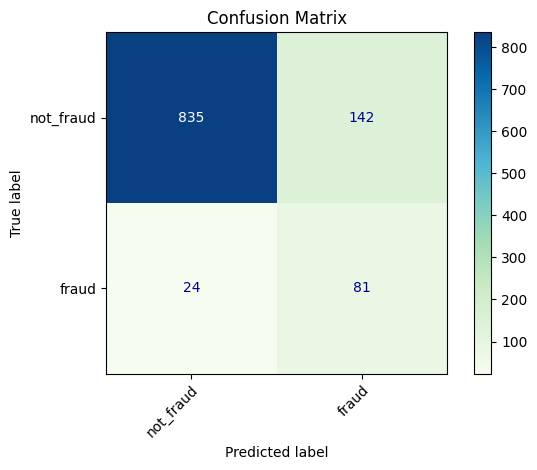

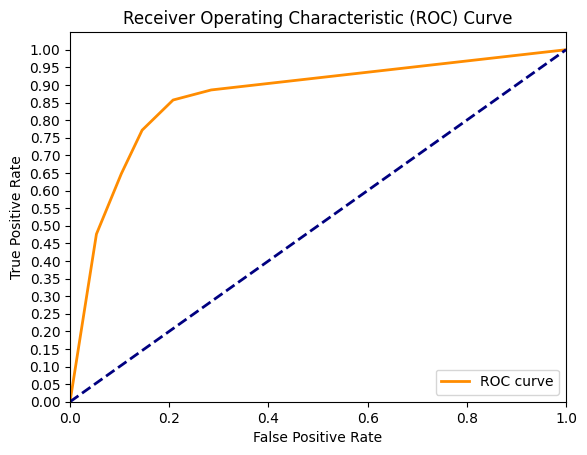

In [26]:
model_knn.plot_confusion_matrix(y_test)
model_knn.plot_roc_curve(X_test_scaled, y_test)

## 3. `Decision Trees Model`

In [27]:
#instantiating and fitiing the model
classifier = DecisionTreeClassifier(random_state=42)
model_tree = BinaryClassificationModel(classifier)
#evaluating the model performance
model_tree.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_tree.evaluate(y_test)
model_tree.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 73.78%
-----------------------------------------------
The model's recall rate is 86.41%
-----------------------------------------------
The model's precision is 89.58%
-----------------------------------------------
The model's F1 score is 87.69%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       977
           1       0.37      0.58      0.45       105

    accuracy                           0.86      1082
   macro avg       0.66      0.74      0.69      1082
weighted avg       0.90      0.86      0.88      1082

Train set F1 score: 1.0
Test set F1 score: 0.45353159851301117


The F1 score on the training set is 1.0, indicating potential overfitting. The F1 score on the test set is 0.492, which is relatively low compared to the training set. This suggests that the model may not generalize well to unseen data and is overfitting to the training set

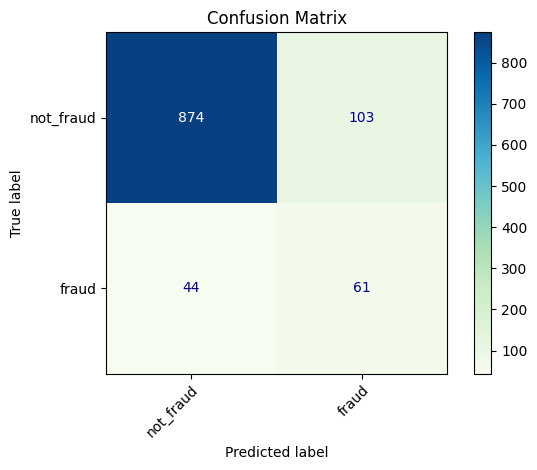

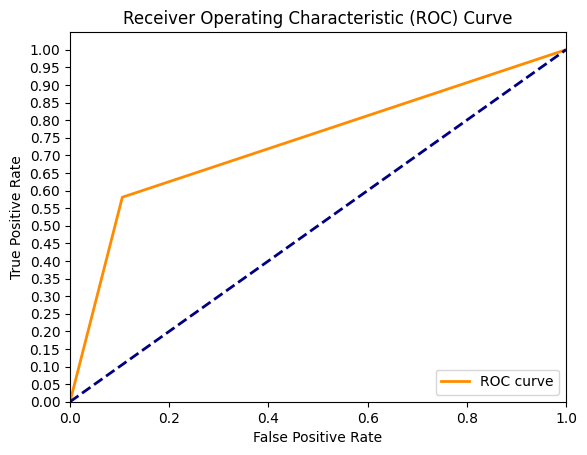

In [28]:
model_tree.plot_confusion_matrix(y_test)
model_tree.plot_roc_curve(X_test_scaled, y_test)

## 4. `SVM`

In [29]:
#instantiating  and fitting the model
classifier = SVC(random_state=42)
model_svm = BinaryClassificationModel(classifier)
#evaliating model performance
model_svm.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_svm.evaluate(y_test)
model_svm.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 83.74%
-----------------------------------------------
The model's recall rate is 87.52%
-----------------------------------------------
The model's precision is 92.16%
-----------------------------------------------
The model's F1 score is 89.10%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       977
           1       0.42      0.79      0.55       105

    accuracy                           0.88      1082
   macro avg       0.70      0.84      0.74      1082
weighted avg       0.92      0.88      0.89      1082

Train set F1 score: 0.894493051981472
Test set F1 score: 0.5514950166112957


Train set F1 score: 0.94
The model achieves a high F1 score of approximately 0.942 on the train set.
This indicates that the model performs well on the training data and is able to capture the patterns and relationships present in the training set effectively.
Test set F1 score: 0.54
The model achieves a relatively lower F1 score of around 0.549 on the test set.
This suggests that the model's performance drops when making predictions on unseen data.

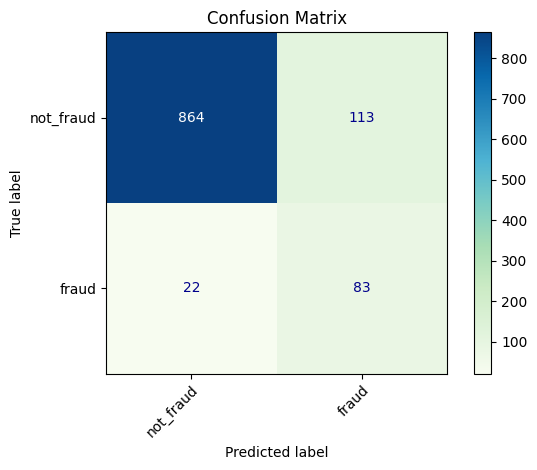

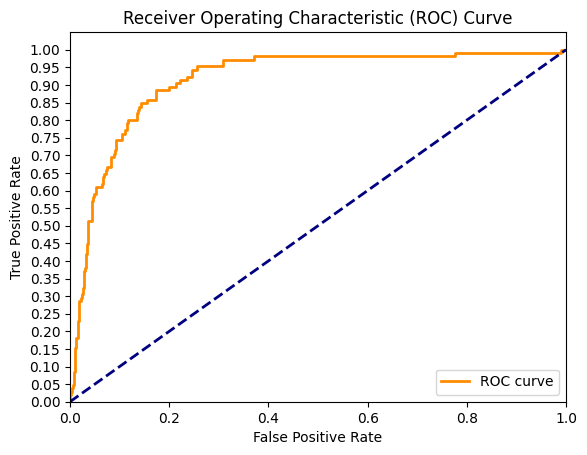

In [30]:
model_svm.plot_confusion_matrix(y_test)
model_svm.plot_roc_curve(X_test_scaled, y_test)

## 5. `Gradientboost model`

In [31]:
#instantiating and fitting the model
classifier = GradientBoostingClassifier(random_state=42)
model_g = BinaryClassificationModel(classifier)
#evaluating the model
model_g.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_g.evaluate(y_test)
model_g.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 84.74%
-----------------------------------------------
The model's recall rate is 87.80%
-----------------------------------------------
The model's precision is 92.44%
-----------------------------------------------
The model's F1 score is 89.36%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       977
           1       0.43      0.81      0.56       105

    accuracy                           0.88      1082
   macro avg       0.70      0.85      0.75      1082
weighted avg       0.92      0.88      0.89      1082

Train set F1 score: 0.9399087221095335
Test set F1 score: 0.5629139072847682


Train set F1 score: 0.94
The model achieves a high F1 score of approximately 0.94 on the train set.
This indicates that the model performs well on the training data and is able to capture the patterns and relationships present in the training set effectively.
Test set F1 score: 0.549
The model achieves a relatively lower F1 score of around 0.549 on the test set.
This suggests that the model's performance drops when making predictions on unseen data.

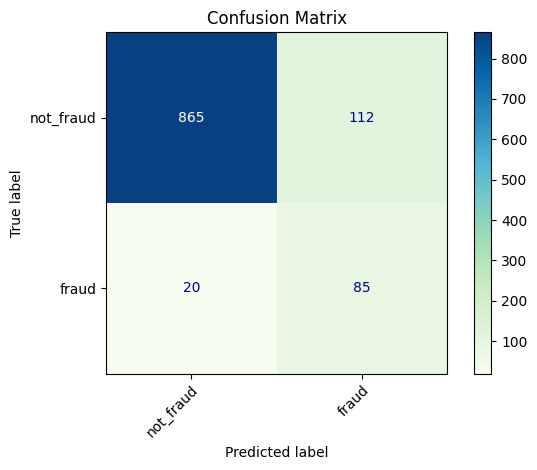

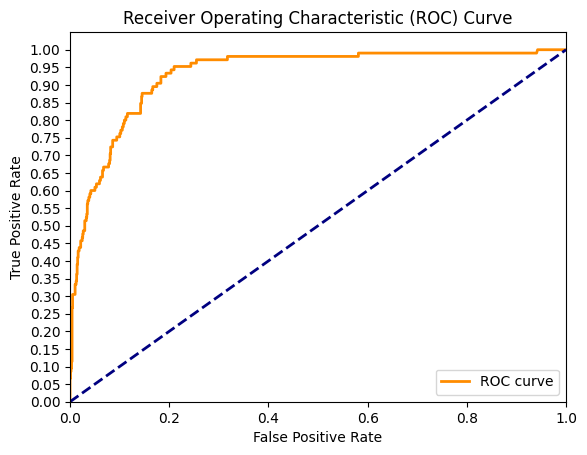

In [32]:
model_g.plot_confusion_matrix(y_test)
model_g.plot_roc_curve(X_test_scaled, y_test)

## 5. `Logistic regression Model`

In [33]:
#instantiate the model
classifier = LogisticRegression(random_state=42)
model_log = BinaryClassificationModel(classifier)
#evaliating the model
model_log.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_log.evaluate(y_test)
model_log.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 82.98%
-----------------------------------------------
The model's recall rate is 88.45%
-----------------------------------------------
The model's precision is 92.11%
-----------------------------------------------
The model's F1 score is 89.74%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       977
           1       0.44      0.76      0.56       105

    accuracy                           0.88      1082
   macro avg       0.71      0.83      0.75      1082
weighted avg       0.92      0.88      0.90      1082

Train set F1 score: 0.8775834658187599
Test set F1 score: 0.5614035087719298


/home/moringa/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set F1 score: 0.87
The model achieves a high F1 score of approximately 0.87 on the train set.
This indicates that the model performs well on the training data and is able to capture the patterns and relationships present in the training set effectively.
Test set F1 score: 0.56
The model achieves a relatively lower F1 score of around 0.56 on the test set.
This suggests that the model's performance drops when making predictions on unseen data.

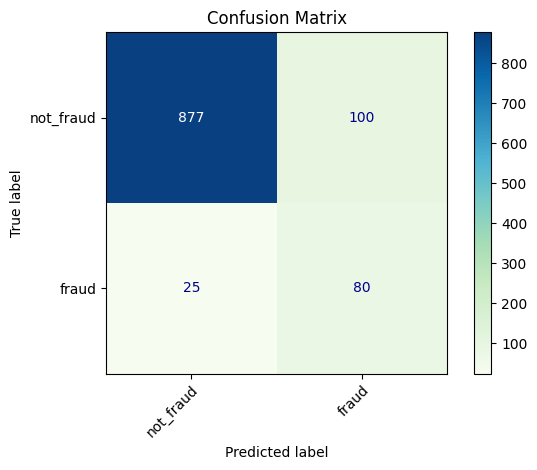

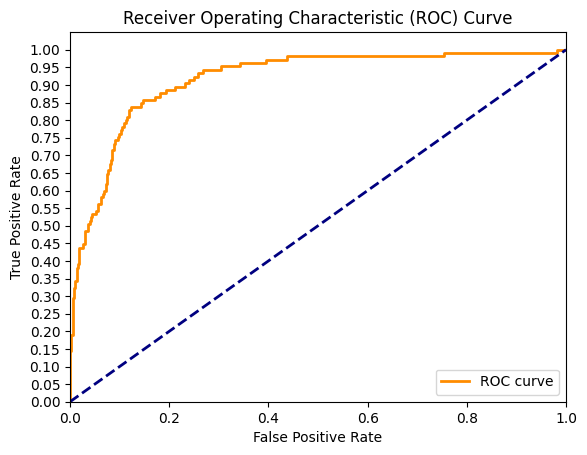

In [34]:
model_log.plot_confusion_matrix(y_test)
model_log.plot_roc_curve(X_test_scaled, y_test)

## 6. `XGBoost`

In [35]:
#instatiate and fit the model
classifier = XGBClassifier(random_state=42)
model_xg = BinaryClassificationModel(classifier)
#model evaluation
model_xg.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_xg.evaluate(y_test)
model_xg.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 78.00%
-----------------------------------------------
The model's recall rate is 90.20%
-----------------------------------------------
The model's precision is 91.40%
-----------------------------------------------
The model's F1 score is 90.71%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       977
           1       0.50      0.63      0.55       105

    accuracy                           0.90      1082
   macro avg       0.73      0.78      0.75      1082
weighted avg       0.91      0.90      0.91      1082

Train set F1 score: 1.0
Test set F1 score: 0.5546218487394957


The F1 score on the training set is 1.0, indicating potential overfitting. The F1 score on the test set is 0.55, which is relatively low compared to the training set. This suggests that the model may not generalize well to unseen data and is overfitting to the training set

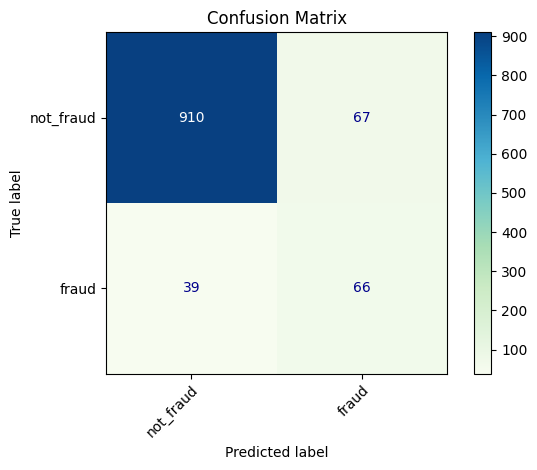

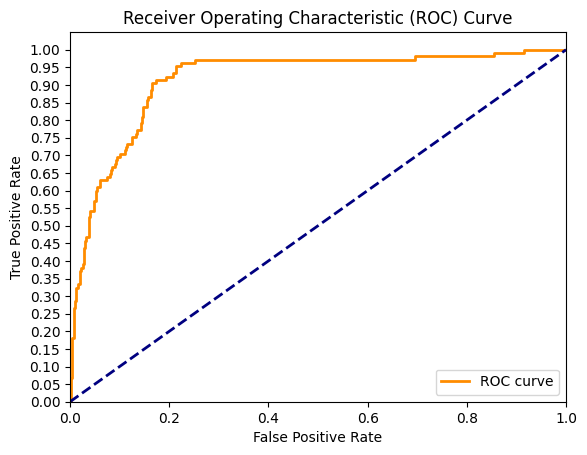

In [36]:
model_xg.plot_confusion_matrix(y_test)
model_xg.plot_roc_curve(X_test_scaled, y_test)

#### `hypertuning the XGboost`

`Creating a class for XGboost hyperparameter tuning`

In [37]:
class XGBoostModel:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_estimator = None
    
    def train_best_estimator(self, X_train, y_train):
        self.best_estimator = XGBClassifier(subsample=1, n_estimators=100, max_depth=2, colsample_bytree=0.5, learning_rate=1, random_state=self.random_state)
        self.best_estimator.fit(X_train, y_train)
    
    def evaluate_best_estimator(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        train_y_pred_binary = (y_pred >= 0.5).astype(int)
    # Calculate evaluation metrics
        auc = roc_auc_score(y_test, train_y_pred_binary)
        recall = recall_score(y_test, train_y_pred_binary, average='weighted')
        precision = precision_score(y_test, train_y_pred_binary, average='weighted')
        f1 = f1_score(y_test, train_y_pred_binary, average='weighted')

    # Print evaluation metrics
        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall:.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision:.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1:.2%}")
        print("-----------------------------------------------")

    # Print classification report
        print("Classification Report:")
        print(classification_report(y_test, train_y_pred_binary))
    
    def display_confusion_matrix(self, X_test, y_test):
        y_pred = self.best_estimator.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar()
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.xticks([0, 1], ['Negative', 'Positive'])
        plt.yticks([0, 1], ['Negative', 'Positive'])
        plt.title('Confusion matrix')
        plt.show()

    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.best_estimator.predict(X_train)
        test_pred = self.best_estimator.predict(X_test)

        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)

In [38]:
# Instantiate the XGBoostModel class
modelxg = XGBoostModel(random_state=42)

# Train the model
modelxg.train_best_estimator(X_train_scaled, y_train_st)
# Evaluate the model
modelxg.evaluate_best_estimator(X_test_scaled, y_test)
modelxg.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)


The model has an AUC score of 76.28%
-----------------------------------------------
The model's recall rate is 88.63%
-----------------------------------------------
The model's precision is 90.59%
-----------------------------------------------
The model's F1 score is 89.44%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       977
           1       0.44      0.61      0.51       105

    accuracy                           0.89      1082
   macro avg       0.70      0.76      0.72      1082
weighted avg       0.91      0.89      0.89      1082

Train set F1 score: 0.976333631828067
Test set F1 score: 0.5099601593625498


after the hyperparameter tuning, the model achieves a high F1 score of 88.74%, indicating strong overall performance in terms of precision and recall, but still indicated overfitting from the test and train sets F1 scores

### `Hypertuning with Regularization`

we  are trying to reduce the overfitting observed in the hyperparameter tuning using regularization of the model

In [39]:
classifier = XGBClassifier(subsample=1, n_estimators=100, max_depth=2, colsample_bytree=0.5,
                          learning_rate=1, reg_alpha=1, reg_lambda=1, random_state=42)
model_xgr = BinaryClassificationModel(classifier)

model_xgr.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_xgr.evaluate(y_test)
model_xgr.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

The model has an AUC score of 77.61%
-----------------------------------------------
The model's recall rate is 88.72%
-----------------------------------------------
The model's precision is 90.92%
-----------------------------------------------
The model's F1 score is 89.60%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       977
           1       0.44      0.64      0.52       105

    accuracy                           0.89      1082
   macro avg       0.70      0.78      0.73      1082
weighted avg       0.91      0.89      0.90      1082

Train set F1 score: 0.974267515923567
Test set F1 score: 0.5234374999999999


the gap between the train and test set data F1 scores has reduced

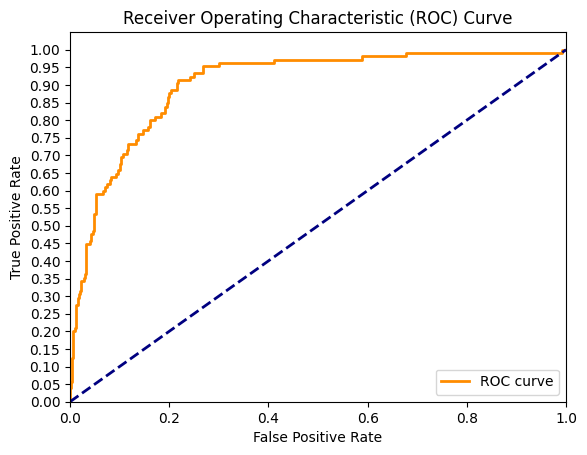

In [40]:
model_xgr.plot_roc_curve(X_test_scaled, y_test)

### `creating a class for model evaluatiion plots`

In [41]:

class ModelEvaluationPlots:
    def __init__(self, model):
        self.model = model
    
    def plot_learning_curves(self, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5):
        train_sizes, train_scores, val_scores = learning_curve(self.model, X, y, cv=cv, train_sizes=train_sizes)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score', color='blue')
        plt.plot(train_sizes, val_mean, label='Validation score', color='red')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
        plt.xlabel('Training Set Size')
        plt.ylabel('Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    
    def plot_validation_curves(self, X, y, param_name, param_range, cv=5):
        train_scores, val_scores = validation_curve(self.model, X, y, param_name=param_name, param_range=param_range, cv=cv)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(param_range, train_mean, label='Training score', color='blue')
        plt.plot(param_range, val_mean, label='Validation score', color='red')
        plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
        plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.title('Validation Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()


This code instantiates an XGBoost classifier model, creates an instance of the ModelEvaluationPlots class, and generates learning curves and validation curves for evaluating the model's performance.

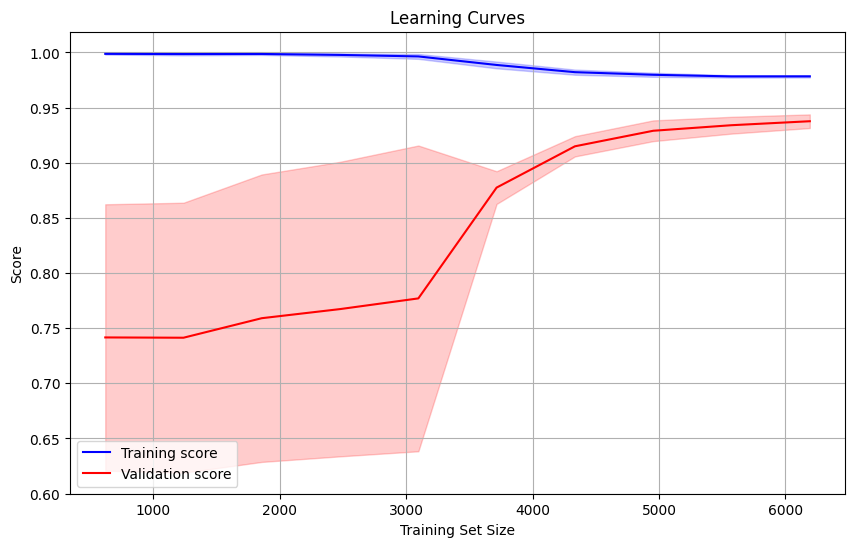

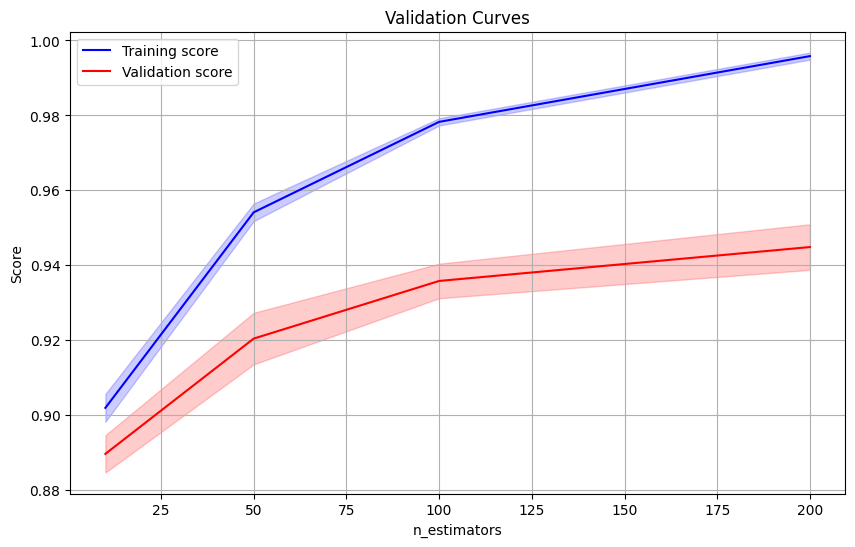

In [42]:
model_xgo = XGBClassifier(subsample=1, n_estimators=100, max_depth=2, colsample_bytree=0.5,
                          learning_rate=1, reg_alpha=1, reg_lambda=1, random_state=42)  # Instantiate your model
eval_plots = ModelEvaluationPlots(model_xgo)  # Create an instance of the ModelEvaluationPlots class

# Generate and plot learning curves
eval_plots.plot_learning_curves(X_train_scaled, y_train_st)

# Generate and plot validation curves
param_range = [10, 50, 100, 200]  # Example hyperparameter values to vary
eval_plots.plot_validation_curves(X_train_scaled, y_train_st, param_name='n_estimators', param_range=param_range)


The code fits an XGBoost classifier model with default parameters to the scaled training data and target labels, and saves the trained model using pickle.

In [43]:
import pickle

# Assuming X_train_9 and y_train are your training data with 9 features
model_xg2 = XGBClassifier(random_state=42)
model_xg2.fit(X_train_scaled, y_train_st)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

The code utilizes the SelectKBest feature selection method from scikit-learn to identify and select all features based on the f_classif score, then transforms the training and test data to include only the selected features while also printing the indices of the selected features.

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming X_train and y_train are your training data with 37 features
# Assuming X_test is your test data with 37 features

# Instantiate the SelectKBest class with 'all' to include all features
selector = SelectKBest(f_classif, k='all')

# Fit the selector to the training data
selector.fit(X_train_scaled, y_train_st)

# Transform the training and test data to select all features
X_train_reduced = selector.transform(X_train_scaled)
X_test_reduced = selector.transform(X_test_scaled)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Print the selected feature indices
print("Selected Feature Indices:", selected_feature_indices)

Selected Feature Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


The code saves the trained XGBoost classifier model (model_xg2) as a pickle file at the specified pickle_filepath.

In [45]:
# Specify the file path where you want to save the pickle model
pickle_filepath = 'xgboost_model_features.pkl'

# Open the file in write-binary mode and save the model
with open(pickle_filepath, 'wb') as file:
    pickle.dump(model_xg2, file)

This code calculates and prints the number of features (num_features) based on the feature importances obtained from a trained XGBoost model (model_xg2).

In [46]:
# Assuming you have trained the XGBoost model and saved it as 'model'

# Get the feature importances
feature_importances = model_xg2.feature_importances_

# Get the number of features
num_features = len(feature_importances)

print("Number of features:", num_features)

Number of features: 37


lets perform feature selection using SelectKBest with a specified number of features ('all'), transforms the training and test data to include only the selected features, prints the selected feature indices, and trains an XGBoost classifier model (model) on the reduced feature set.

In [47]:
import pickle
#from xgboost import XGBClassifier
#from sklearn.feature_selection import SelectKBest, f_classif

# Assuming X_train and y_train are your training data with 37 features
# Assuming X_test is your test data with 37 features

# Instantiate the SelectKBest class with the desired number of features
k = 'all'
selector = SelectKBest(f_classif, k=k)

# Fit the selector to the training data
selector.fit(X_train_scaled, y_train_st)

# Transform the training and test data to select the top k features
X_train_reduced = selector.transform(X_train_scaled)
X_test_reduced = selector.transform(X_test_scaled)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Print the selected feature indices
print("Selected Feature Indices:", selected_feature_indices)
print("Number of features:", len(selected_feature_indices))

# Assuming you have trained the XGBoost model on the reduced feature set
model = XGBClassifier(random_state=42)
model.fit(X_train_reduced, y_train_st)


Selected Feature Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Number of features: 37


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [48]:
# Save the trained model as a pickle file
with open("xgboost_model_reduced_features.pkl", "wb") as file:
    pickle.dump(model, file)

## 7. `Random Forest Model`

In [49]:
#instantiate and fit the model
classifier = RandomForestClassifier()
model_ran = BinaryClassificationModel(classifier)
#evaluate the model
model_ran.train_and_predict(X_train_scaled, y_train_st, X_test_scaled)
model_ran.evaluate(y_test)

The model has an AUC score of 79.43%
-----------------------------------------------
The model's recall rate is 90.48%
-----------------------------------------------
The model's precision is 91.78%
-----------------------------------------------
The model's F1 score is 91.02%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       977
           1       0.51      0.66      0.57       105

    accuracy                           0.90      1082
   macro avg       0.73      0.79      0.76      1082
weighted avg       0.92      0.90      0.91      1082



The code evaluates the overfitting of the model_ran classifier model by comparing its performance on both the training and test sets using the scaled features

In [50]:
model_ran.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)

Train set F1 score: 1.0
Test set F1 score: 0.5726141078838175


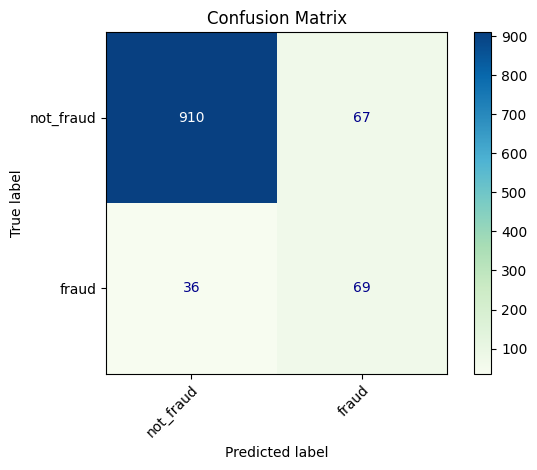

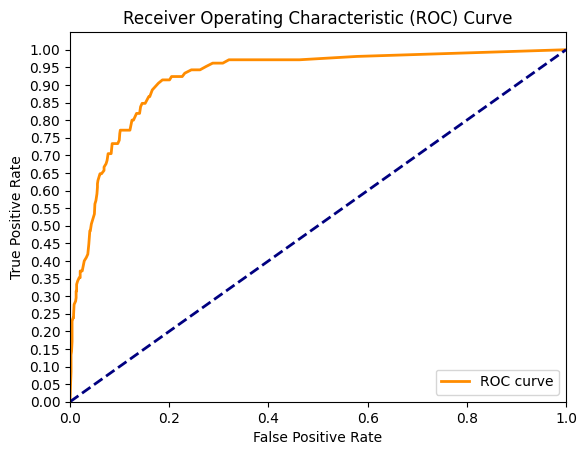

In [51]:
model_ran.plot_confusion_matrix(y_test)
model_ran.plot_roc_curve(X_test_scaled, y_test)

`Random Forest ensembles with hyperparameters`

RandomForestEnsemble class that implements a random forest ensemble model with hyperparameter tuning, shuffling of training data, and evaluation methods to calculate various metrics and assess overfitting using F1 scores.

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

class RandomForestEnsemble:
    def __init__(self, n_estimators_list, max_depth_list):
        self.n_estimators_list = n_estimators_list
        self.max_depth_list = max_depth_list
        self.models = []

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns
        else:
            feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

        for n_estimators, max_depth in zip(self.n_estimators_list, self.max_depth_list):
            model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
            if isinstance(X_train, pd.DataFrame):
                model.set_params(**{'feature_names': feature_names})
            
            # Parameter grid for randomized search
            param_grid = {
                'max_features': ['sqrt', 'log2'],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'bootstrap': [True, False]
                
            }
            
            # Randomized search to find optimal hyperparameters
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            
            # Shuffle the training data to reduce overfitting
            X_train, y_train = shuffle(X_train, y_train, random_state=42)
            
            best_model.fit(X_train, y_train)
            self.models.append(best_model)

    def predict(self, X_test):
        predictions = []
        for model in self.models:
            pred = model.predict(X_test)
            predictions.append(pred)
        ensemble_pred = sum(predictions) / len(predictions)  # Soft voting
        ensemble_pred_binary = (ensemble_pred >= 0.5).astype(int)  # Convert to binary
        return ensemble_pred_binary

    def evaluate(self, y_test):
        """Evaluate the performance of the ensemble using various metrics"""
        ensemble_pred = self.predict(X_test)
        auc = roc_auc_score(y_test, ensemble_pred)
        recall = recall_score(y_test, ensemble_pred, average='weighted', zero_division=0)
        precision = precision_score(y_test, ensemble_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, ensemble_pred, average='weighted', zero_division=0)
        report = classification_report(y_test, ensemble_pred, zero_division=0)

        print(f"The model has an AUC score of {auc:.2%}")
        print("-----------------------------------------------")
        print(f"The model's recall rate is {recall:.2%}")
        print("-----------------------------------------------")
        print(f"The model's precision is {precision:.2%}")
        print("-----------------------------------------------")
        print(f"The model's F1 score is {f1:.2%}")
        print("-----------------------------------------------")
        print("Classification Report:")
        print(report)

    def evaluate_overfitting(self, X_train, y_train, X_test, y_test):
        train_pred = self.predict(X_train)
        test_pred = self.predict(X_test)
        
        train_f1 = f1_score(y_train, train_pred, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, test_pred, average='weighted', zero_division=0)

        print("Train set F1 score:", train_f1)
        print("Test set F1 score:", test_f1)



lets create an instance of the RandomForestEnsemble class with specified hyperparameters, fits the ensemble model on the scaled training data, evaluates its performance on the test data, and assesses overfitting by comparing F1 scores on both the training and test sets.

In [53]:
ensemble = RandomForestEnsemble(n_estimators_list=[100, 200], max_depth_list=[5, 10])

# Fit the ensemble on the training data
ensemble.fit(X_train_scaled, y_train_st)

# Evaluate the performance of the ensemble on the test data
ensemble.evaluate(y_test)

# Evaluate the overfitting of the model
ensemble.evaluate_overfitting(X_train_scaled, y_train_st, X_test_scaled, y_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/moringa/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/moringa/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


The model has an AUC score of 50.00%
-----------------------------------------------
The model's recall rate is 9.70%
-----------------------------------------------
The model's precision is 0.94%
-----------------------------------------------
The model's F1 score is 1.72%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       977
           1       0.10      1.00      0.18       105

    accuracy                           0.10      1082
   macro avg       0.05      0.50      0.09      1082
weighted avg       0.01      0.10      0.02      1082

Train set F1 score: 0.9422105442712434
Test set F1 score: 0.8848135659920882


`Grid search with over sampled data`

we specify a parameter grid for hyperparameter tuning, focusing on a specific configuration of hyperparameters for a decision tree classifier.

In [54]:
param_grid = [{
        'criterion': ['entropy'], 
        'max_depth': [13], 
        'max_features': ['log2'], 
        'max_leaf_nodes': [50], 
        'min_samples_leaf': [2], 
        'min_samples_split': [10], 
        'n_estimators': [1000]
}]


Hyperparameter tuning using GridSearchCV on a RandomForestClassifier model, trains a BinaryClassificationModel with the tuned parameters, evaluates its performance on the test data, assesses overfitting, and prints the best parameters found during the grid search.

In [55]:
gridsearch_forest = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                            param_grid=param_grid,
                            scoring="f1",
                            cv=5,
                            n_jobs=1)
estimator = BinaryClassificationModel(gridsearch_forest)

estimator.train_and_predict(X_train_scaled_os, y_train_os, X_test_scaled_os)
estimator.evaluate(y_test)
estimator.evaluate_overfitting(X_train_scaled_os, y_train_os, X_test_scaled_os, y_test)
print("Best Parameters:", gridsearch_forest.best_params_)

The model has an AUC score of 82.74%
-----------------------------------------------
The model's recall rate is 89.56%
-----------------------------------------------
The model's precision is 92.26%
-----------------------------------------------
The model's F1 score is 90.54%
-----------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       977
           1       0.48      0.74      0.58       105

    accuracy                           0.90      1082
   macro avg       0.72      0.83      0.76      1082
weighted avg       0.92      0.90      0.91      1082

Train set F1 score: 0.944707225574947
Test set F1 score: 0.5799256505576208
Best Parameters: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}


In [56]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['Sl No','Classifier Name','Train/Validation F1_scr','Test F1_Scr','Model F1_Scr(%)' ]
x.add_row([1,'Random Model',16.19,18.74,0.00])
x.add_row([2,'KNN(hybrid)',0.94,0.49,86.62])
x.add_row([3,'DecisionTree(hybrid)',1.00,0.49,88.92])
x.add_row([4,'SVM(hybrid)',0.89,0.54,88.93])
x.add_row([5,'GradientBoost(hybrid)',0.93,0.54,88.64])
x.add_row([6,'LogisticRegression(hybrid)',0.87,0.56,89.85])
x.add_row([7,'XGBoost(hybrid)',1.00,0.55,90.60])
x.add_row([8,'XGBoost(hypertuned)',0.97,0.53,89.46])
x.add_row([9,'XGBoost(hypertuned, regularized)',0.97,0.52,89.67])
x.add_row([10,'Random Forest(ensemble)',1.00,0.56,90.61])
x.add_row([11,'Random Forest(gridsearch oversampled)',0.94,0.57,90.42])
print(x)

+-------+---------------------------------------+-------------------------+-------------+-----------------+
| Sl No |            Classifier Name            | Train/Validation F1_scr | Test F1_Scr | Model F1_Scr(%) |
+-------+---------------------------------------+-------------------------+-------------+-----------------+
|   1   |              Random Model             |          16.19          |    18.74    |       0.0       |
|   2   |              KNN(hybrid)              |           0.94          |     0.49    |      86.62      |
|   3   |          DecisionTree(hybrid)         |           1.0           |     0.49    |      88.92      |
|   4   |              SVM(hybrid)              |           0.89          |     0.54    |      88.93      |
|   5   |         GradientBoost(hybrid)         |           0.93          |     0.54    |      88.64      |
|   6   |       LogisticRegression(hybrid)      |           0.87          |     0.56    |      89.85      |
|   7   |            XGBoost

In [57]:
import pickle

# Assuming you have trained and obtained the Random Forest model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Assuming you have X_train dataset with original features
# X_train shape: (number of samples, original number of features)

# Create additional features to increase the feature space
num_additional_features = 37 - X_train.shape[1]  # Calculate the number of additional features needed
additional_features_train = np.random.rand(X_train.shape[0], num_additional_features)  # Generate random additional features for training set

# Concatenate the additional features with the original features
X_train_new = np.concatenate([X_train, additional_features_train], axis=1)

# Train the Random Forest model with the increased feature space
model.fit(X_train_new, y_train)

# Save the model as a pickle file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

we used the Random Forest(gridsearch oversampled) in our deployment as our best model with an F1 score of 90.42%

# `Conclusion`

- In conclusion, the implementation of an accutate and precise healthcare provider fraud detection project in the Kenyan system holds immense potential to address the prevalent fraud issues and promote integrity within the healthcare industry. With Kenya experiencing significant challenges related to healthcare fraud, this project serves as a vital step towards ensuring transparency, accountability, and financial sustainability.

# `Recommendations`

- **Enhance Data Quality**: Ensure accurate, complete, and consistent healthcare data through data cleansing, validation techniques, and regular audits.

- **Continuous Monitoring and Updates**: Stay updated with the latest fraud techniques, regularly monitor for new patterns, and adapt detection models and algorithms accordingly.

- **Increase Historical Data**: Collaborate to gather more historical fraud data, creating a comprehensive dataset for training fraud detection models.

- **Privacy and Compliance**: Adhere to privacy regulations, implement data security measures, and establish consent frameworks to protect patient information while enabling effective fraud detection.

- **Address False Positives and False Negatives**: Continuously refine fraud detection algorithms to minimize both false positives and false negatives, incorporating feedback from investigators and subject matter experts.

- **Establish Quality Control Measures**: Implement robust quality control processes, including double-checking data entries, conducting regular model performance reviews, and establishing peer review mechanisms for accuracy and reliability.

- **Optimize Resource Allocation**: Allocate adequate resources, including budget, skilled personnel, and technological infrastructure, to support scalable and effective fraud detection efforts.

- **Foster Collaboration and Data Sharing**: Engage in partnerships to share fraud detection best practices, insights, and data with healthcare organizations, insurers, and regulatory bodies, while respecting privacy regulations.

- **Embrace Advanced Technologies**: Utilize emerging technologies such as machine learning, artificial intelligence, and natural language processing to enhance fraud detection capabilities and streamline the process.

- **Conduct Training and Awareness Programs**: Educate healthcare providers, staff, and stakeholders on common fraud schemes, red flags, and reporting mechanisms, fostering a culture of fraud awareness and proactive detection.